Written by AI22BTECH11001

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import matplotlib.pyplot as plt
import numpy as np

/home/aviator98/anaconda3/envs/python3.11_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/aviator98/anaconda3/envs/python3.11_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import torch
from torchvision import datasets, transforms

# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Calculate the lengths for training and validation sets
train_size = int(0.7 * len(full_train_dataset))
val_size = int(0.1 * len(full_train_dataset))
test_size = len(full_train_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, _ = torch.utils.data.random_split(full_train_dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(train_loader), len(val_loader), len(test_loader)) 

1313 188 313


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

cpu


In [8]:
import torch
import torch.nn as nn
from torch.autograd import grad
from tqdm import tqdm

def compute_loss(model, x, y):
    criterion = nn.CrossEntropyLoss()
    output = model(x)
    return criterion(output, y)

def get_influence_on_test_loss(model, train_loader, test_sample, test_label, damping=0.01, scale=25.0):
    model.eval()
    
    # Compute loss on test point and get gradient wrt parameters
    test_sample = test_sample.unsqueeze(0)  # Add batch dimension
    test_label = torch.tensor([test_label], dtype=torch.long).to(device)
    
    test_loss = compute_loss(model, test_sample, test_label)
    test_grad = grad(test_loss, model.parameters(), create_graph=True)

    # Flatten test gradients into a single vector
    test_grad_vec = torch.cat([g.contiguous().view(-1) for g in test_grad])

    # Hessian-vector product approximation using LiSSA
    v = test_grad_vec.detach()
    h_estimate = v.clone()
    for _ in range(int(scale)):
        model.zero_grad()
        train_loss = compute_loss(model, test_sample, test_label)
        grads = grad(train_loss, model.parameters(), create_graph=True)
        flat_grads = torch.cat([g.contiguous().view(-1) for g in grads])
        grad_v = torch.dot(flat_grads, h_estimate)  # scalar
        hv = grad(grad_v, model.parameters(), retain_graph=True)
        hv_vec = torch.cat([g.contiguous().view(-1) for g in hv]).detach()


    # Now compute influence of each training point
    influences = []
    for images, labels in tqdm(train_loader, desc="Computing influence"):
        for i in range(images.size(0)):
            xi = images[i].unsqueeze(0).to(device)
            yi = torch.tensor([labels[i]], dtype=torch.long).to(device)

            model.zero_grad()
            train_loss_i = compute_loss(model, xi, yi)
            train_grad = grad(train_loss_i, model.parameters(), retain_graph=False)
            train_grad_vec = torch.cat([g.contiguous().view(-1) for g in train_grad])

            influence = -torch.dot(h_estimate, train_grad_vec).item()
            influences.append((influence, xi.cpu(), yi.cpu().item()))

    # Sort by influence (most negative = most helpful)
    influences.sort(key=lambda x: x[0])
    return influences


In [4]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPool
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)  # Output layer
        return x

In [5]:
# Load model and set to evaluation mode
model = CNN().to(device)
model.load_state_dict(torch.load("mnist_cnn_lime.pth", map_location=device))
model.eval()

# Function to get one sample for classes 4 to 7
def get_selected_samples(test_loader, selected_classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
    selected_samples = {}
    for images, labels in test_loader:
        for i in range(len(labels)):
            label = labels[i].item()
            if label in selected_classes and label not in selected_samples:
                selected_samples[label] = images[i].to(device)
            if len(selected_samples) == len(selected_classes):
                return selected_samples
    return selected_samples

# Fetch samples for classes 4 to 7
selected_samples = get_selected_samples(test_loader)

cpu


/home/aviator98/anaconda3/envs/python3.11_env/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/tmp/ipykernel_23360/3340426702.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer b

Computing influence: 100%|██████████| 1313/1313 [00:50<00:00, 26.03it/s]


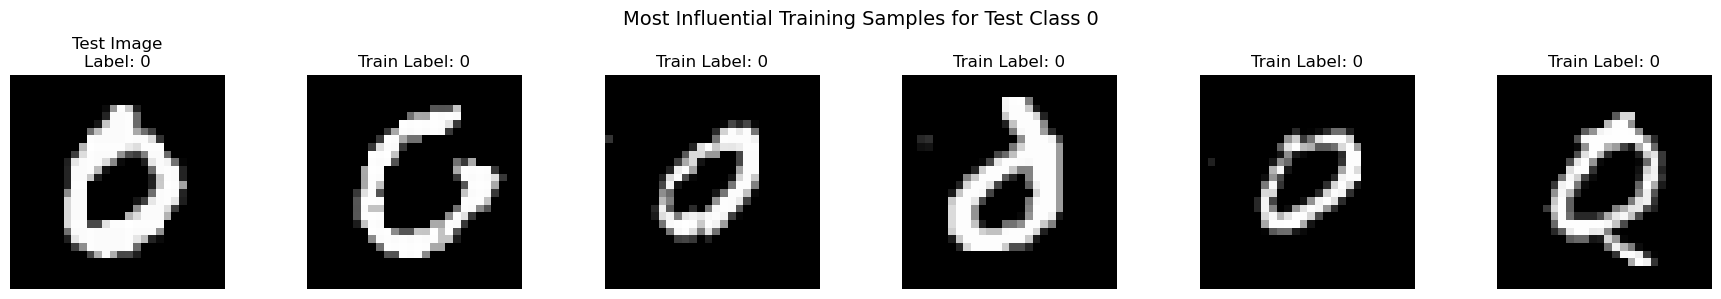

Computing influence: 100%|██████████| 1313/1313 [00:49<00:00, 26.50it/s]


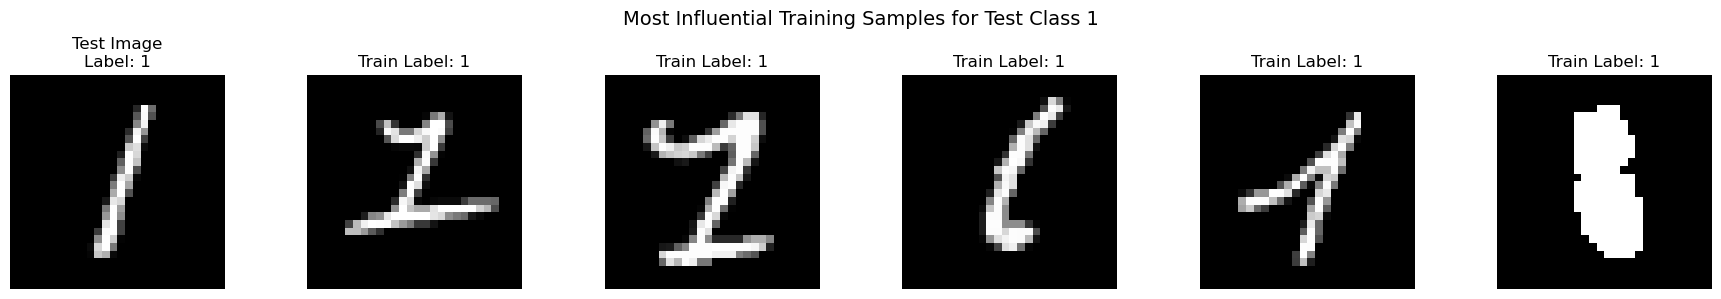

Computing influence: 100%|██████████| 1313/1313 [00:49<00:00, 26.48it/s]


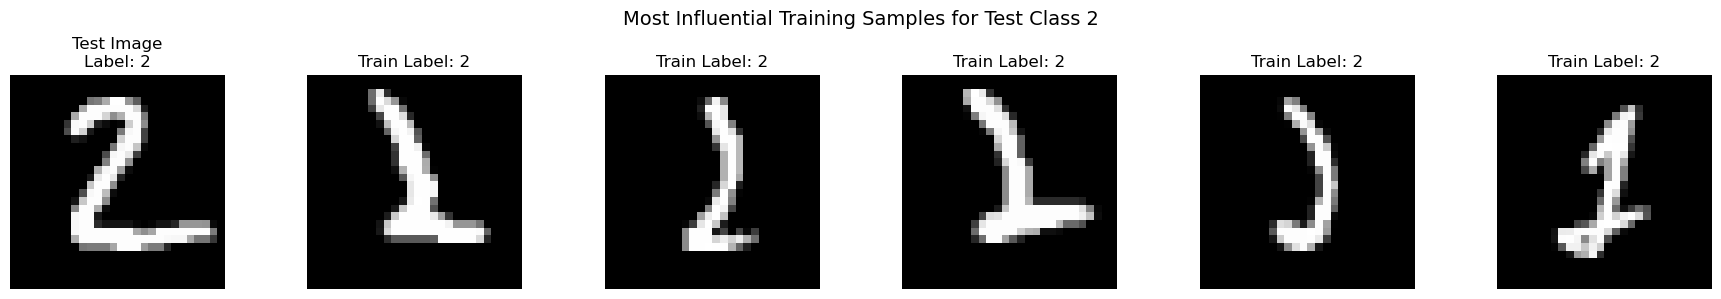

Computing influence: 100%|██████████| 1313/1313 [00:46<00:00, 27.96it/s]


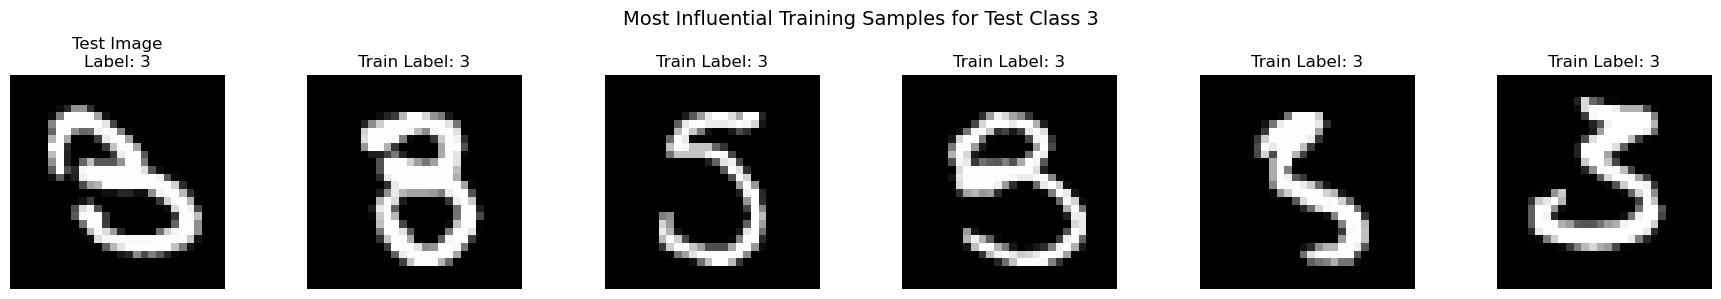

Computing influence: 100%|██████████| 1313/1313 [00:47<00:00, 27.61it/s]


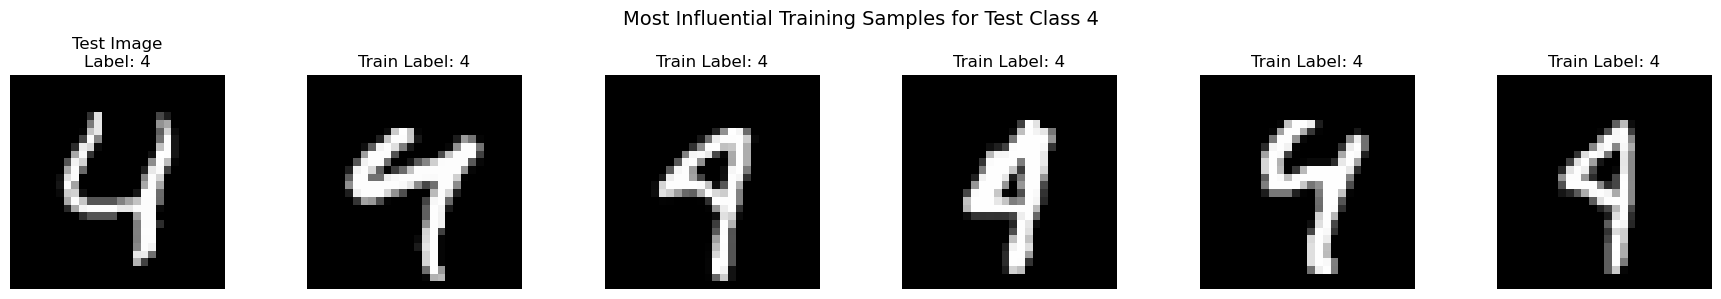

Computing influence: 100%|██████████| 1313/1313 [00:54<00:00, 24.01it/s]


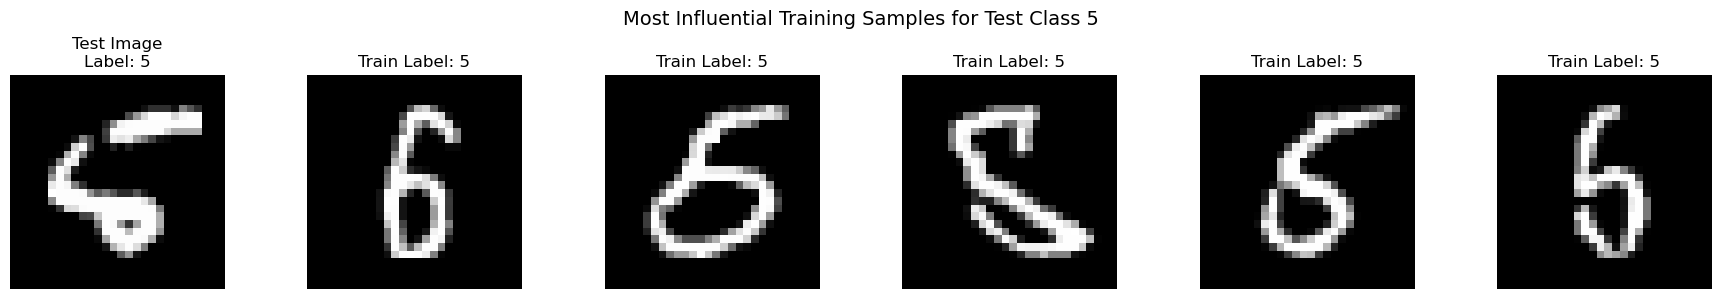

Computing influence: 100%|██████████| 1313/1313 [00:46<00:00, 28.35it/s]


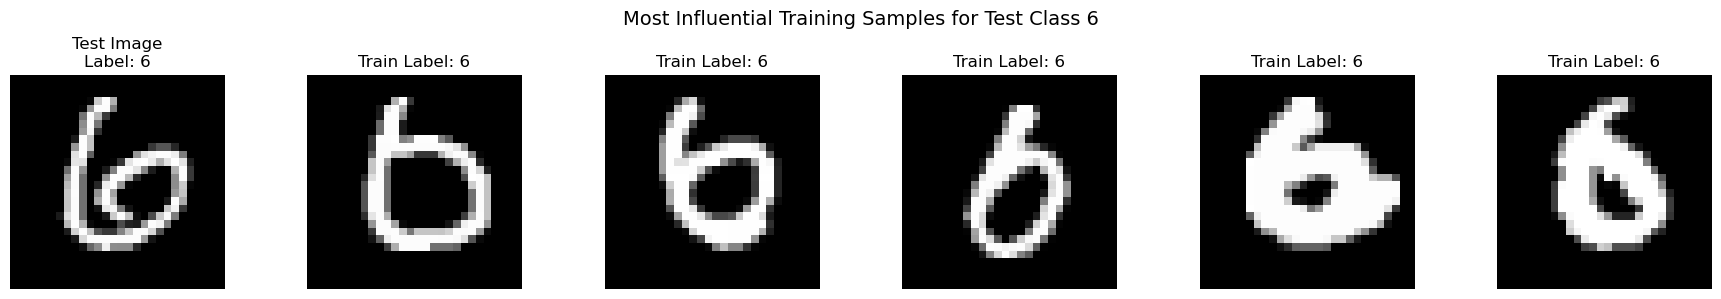

Computing influence: 100%|██████████| 1313/1313 [00:40<00:00, 32.28it/s]


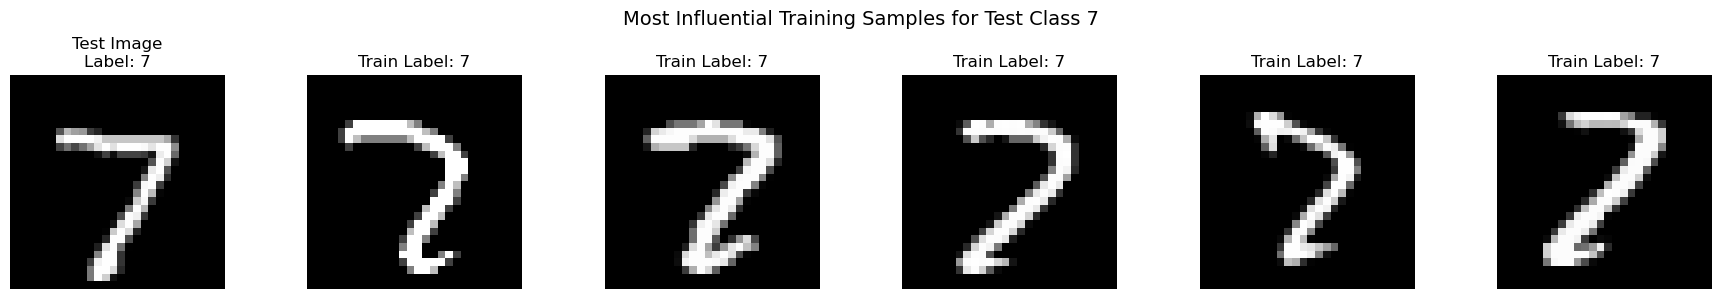

Computing influence: 100%|██████████| 1313/1313 [00:41<00:00, 31.82it/s]


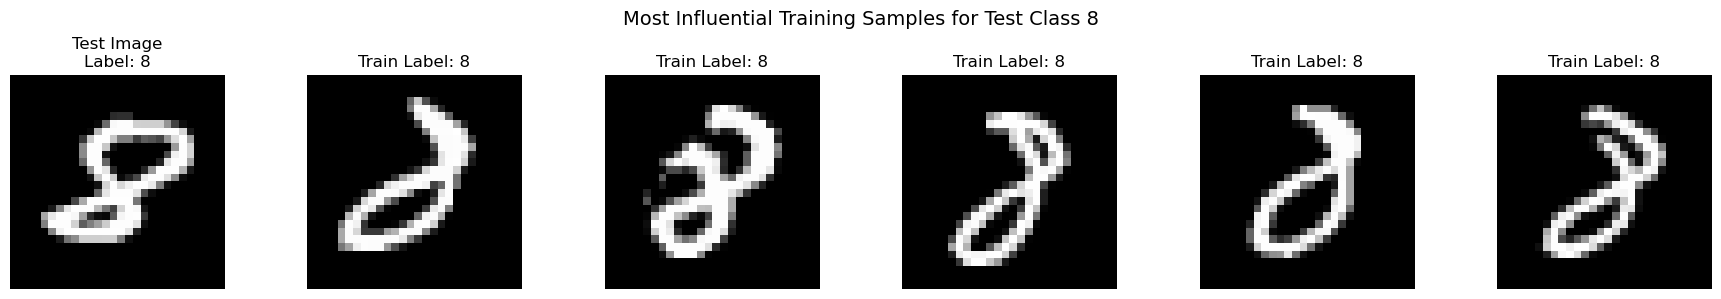

Computing influence: 100%|██████████| 1313/1313 [00:41<00:00, 31.54it/s]


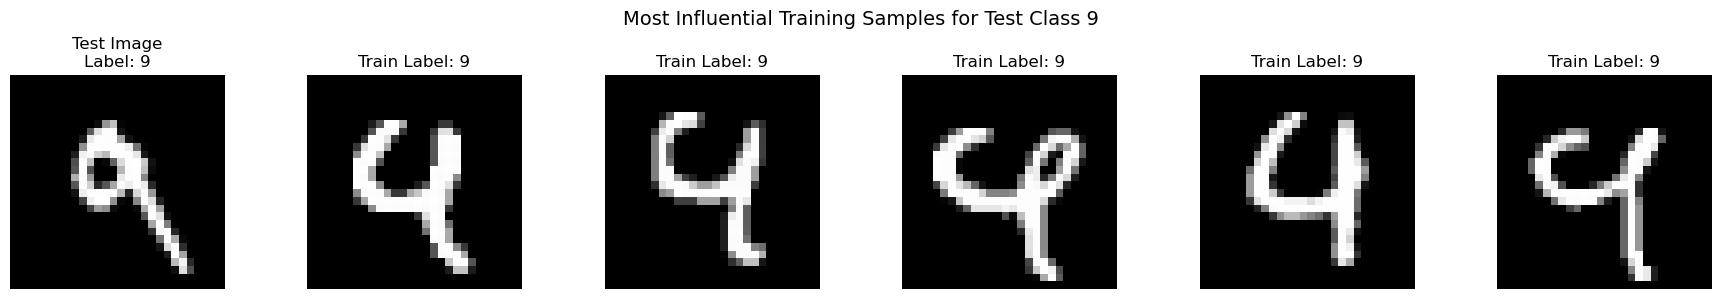

In [13]:
for i in range(len(selected_samples)):
    # Compute influence for a test sample (e.g., class 4)
    test_sample = selected_samples[i]
    test_label = i


    influences = get_influence_on_test_loss(model, train_loader, test_sample, test_label)

    import matplotlib.pyplot as plt

    # Create a 1x6 subplot: 1 for test image + 5 influential training samples
    fig, axes = plt.subplots(1, 6, figsize=(18, 3))

    # Plot the test image
    test_img = test_sample.squeeze()
    axes[0].imshow(test_img, cmap='gray')
    axes[0].set_title(f"Test Image\nLabel: {test_label}")
    axes[0].axis('off')

    # Plot the 5 most influential training images
    for i in range(5):
        img = influences[i][1].squeeze()
        label = influences[i][2]
        axes[i + 1].imshow(img, cmap='gray')
        axes[i + 1].set_title(f"Train Label: {label}")
        axes[i + 1].axis('off')

    plt.suptitle(f"Most Influential Training Samples for Test Class {test_label}", fontsize=14)
    plt.tight_layout()
    plt.show()


Computing influence: 100%|██████████| 1313/1313 [00:52<00:00, 24.78it/s]


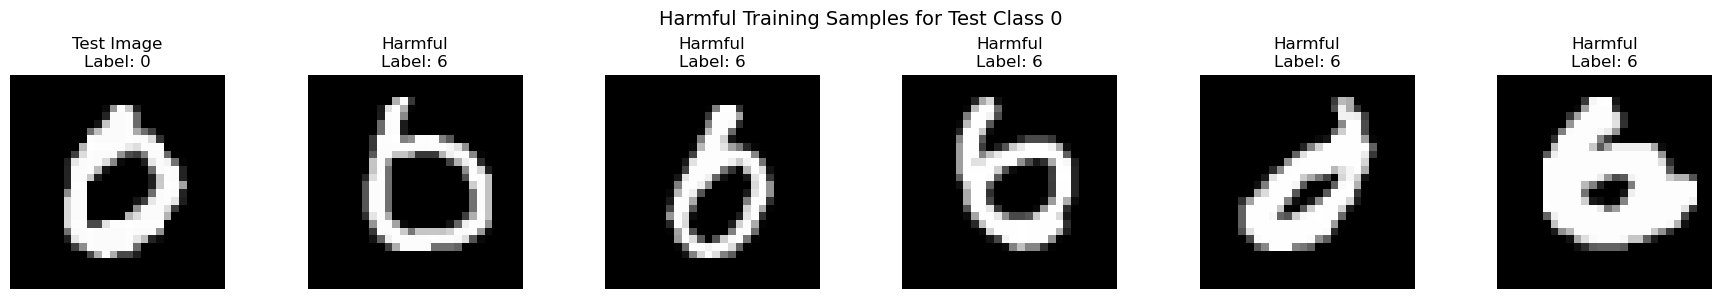

Computing influence: 100%|██████████| 1313/1313 [00:50<00:00, 26.09it/s]


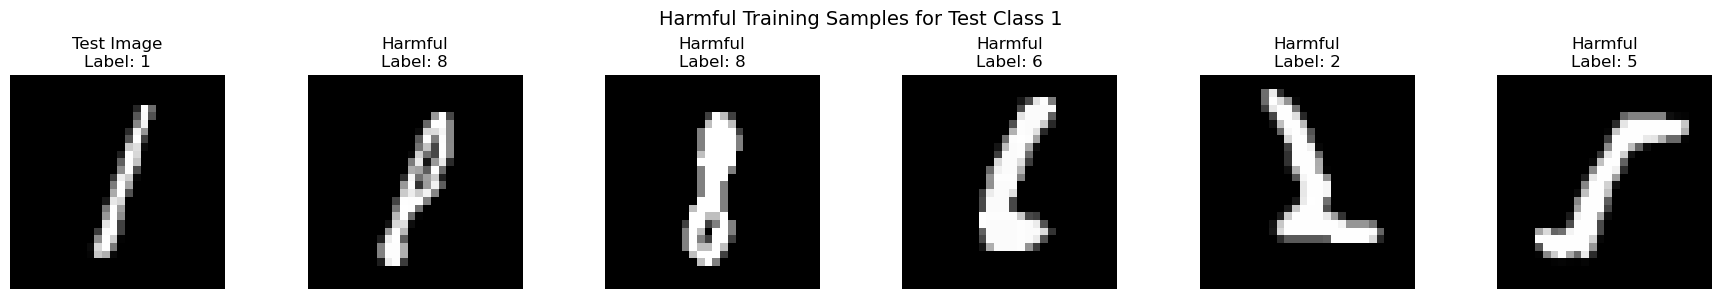

Computing influence: 100%|██████████| 1313/1313 [00:48<00:00, 27.20it/s]


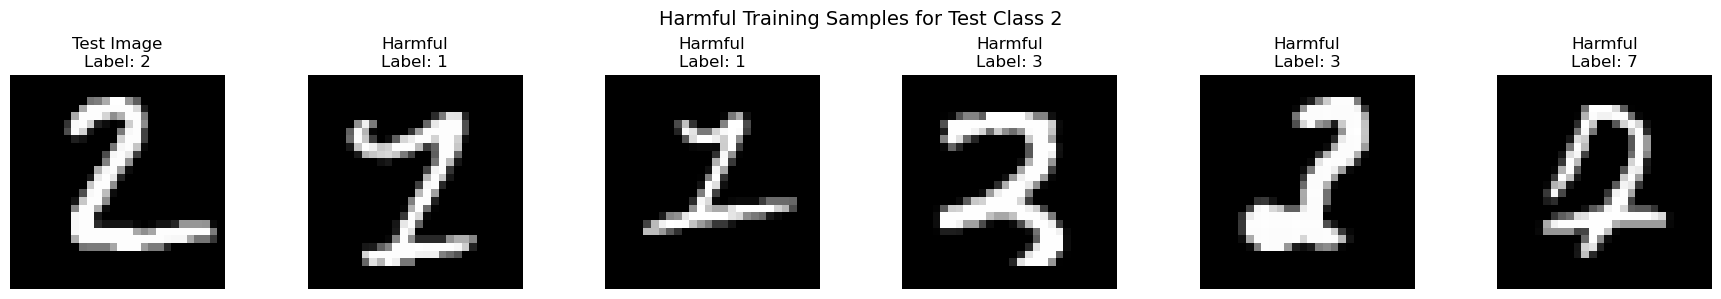

Computing influence: 100%|██████████| 1313/1313 [00:50<00:00, 26.13it/s]


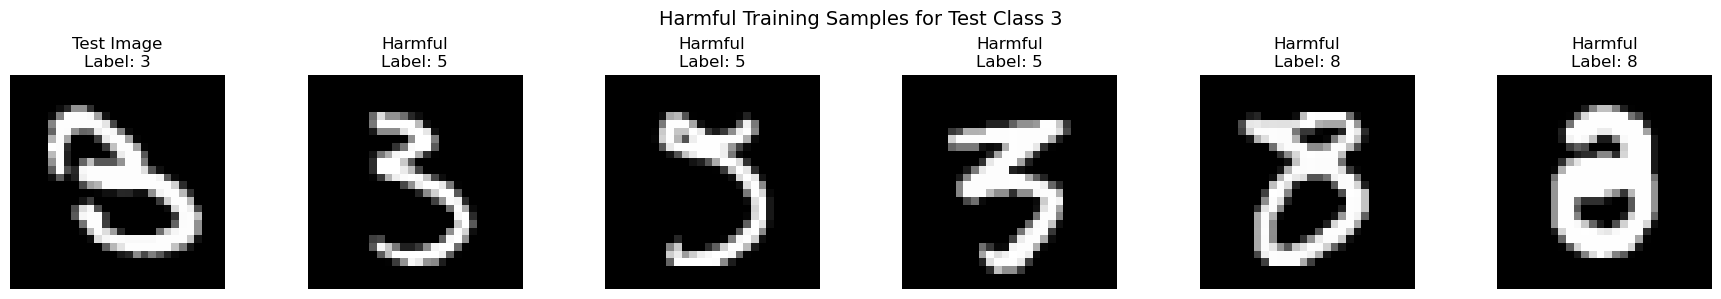

Computing influence: 100%|██████████| 1313/1313 [00:50<00:00, 26.24it/s]


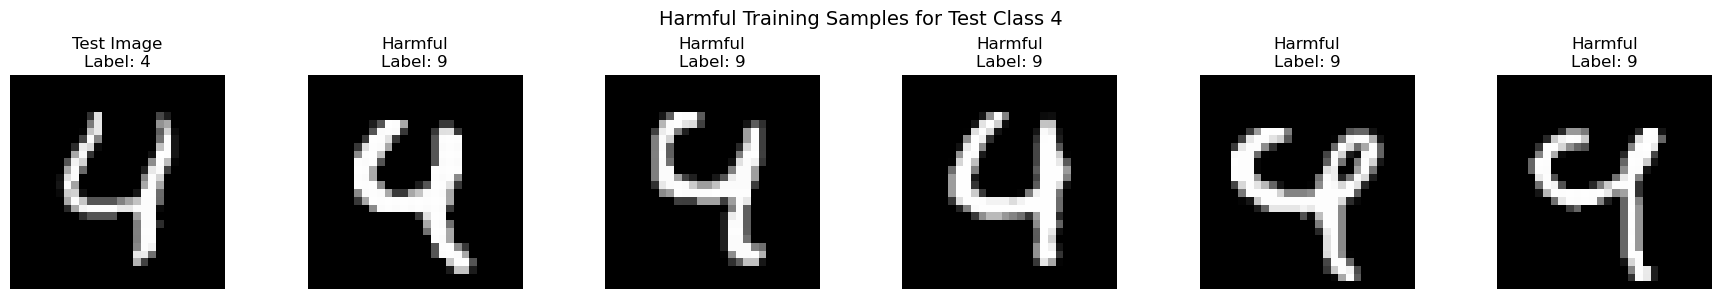

Computing influence: 100%|██████████| 1313/1313 [00:52<00:00, 24.98it/s]


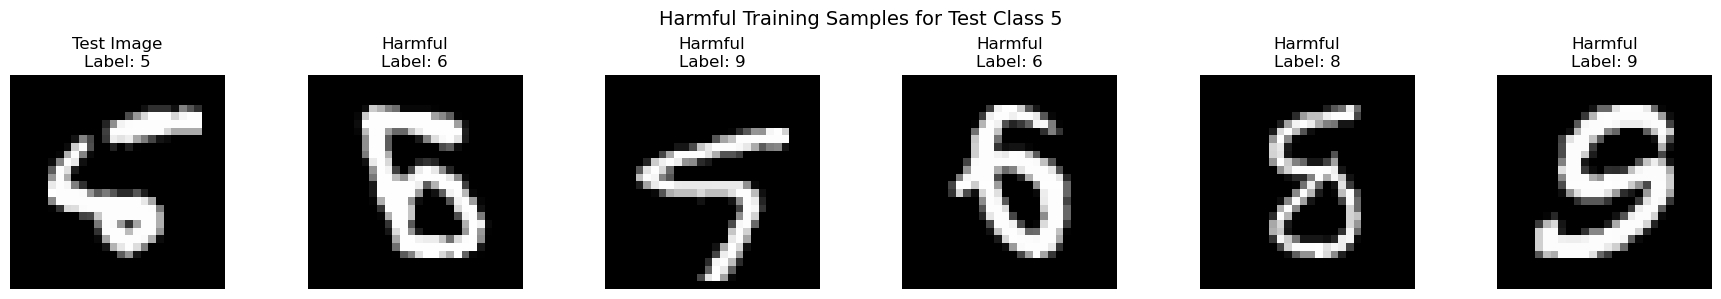

Computing influence: 100%|██████████| 1313/1313 [00:51<00:00, 25.37it/s]


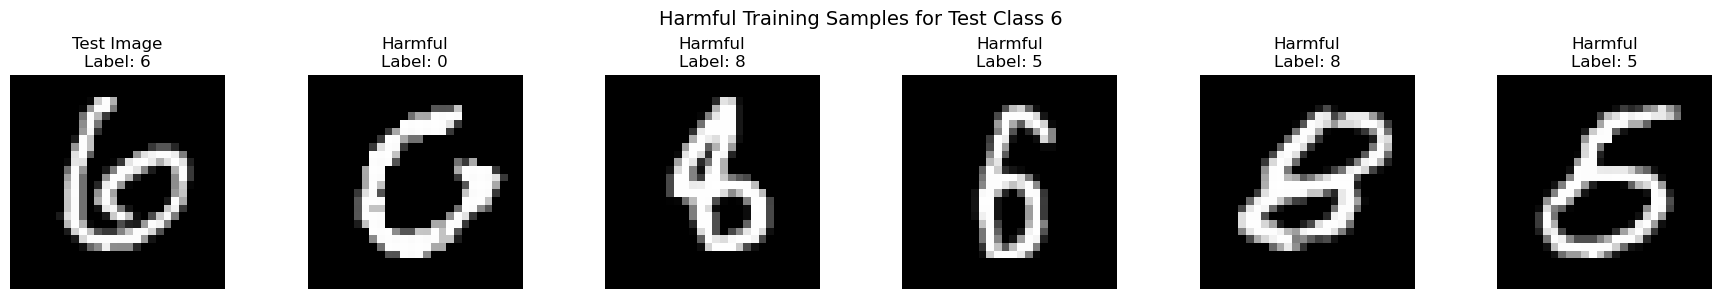

Computing influence: 100%|██████████| 1313/1313 [00:52<00:00, 24.86it/s]


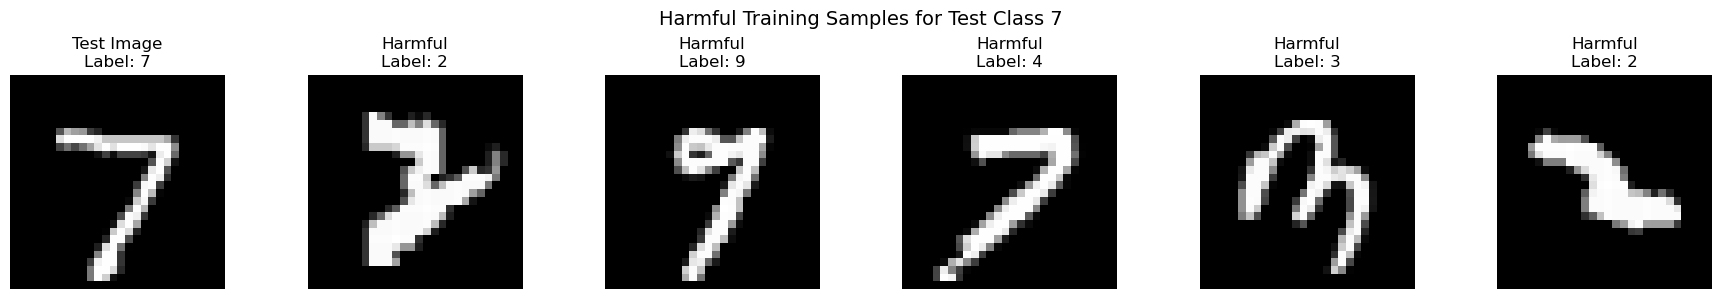

Computing influence: 100%|██████████| 1313/1313 [00:51<00:00, 25.65it/s]


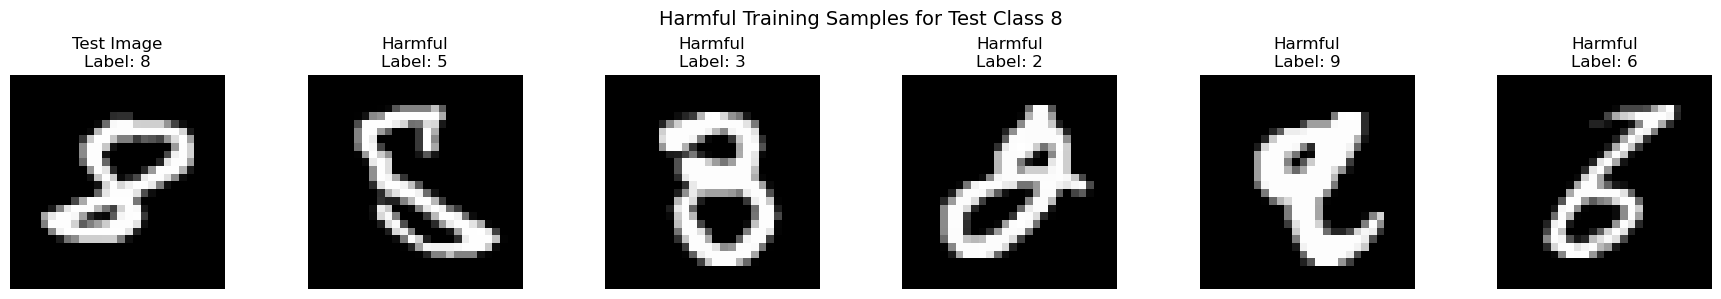

Computing influence: 100%|██████████| 1313/1313 [00:55<00:00, 23.69it/s]


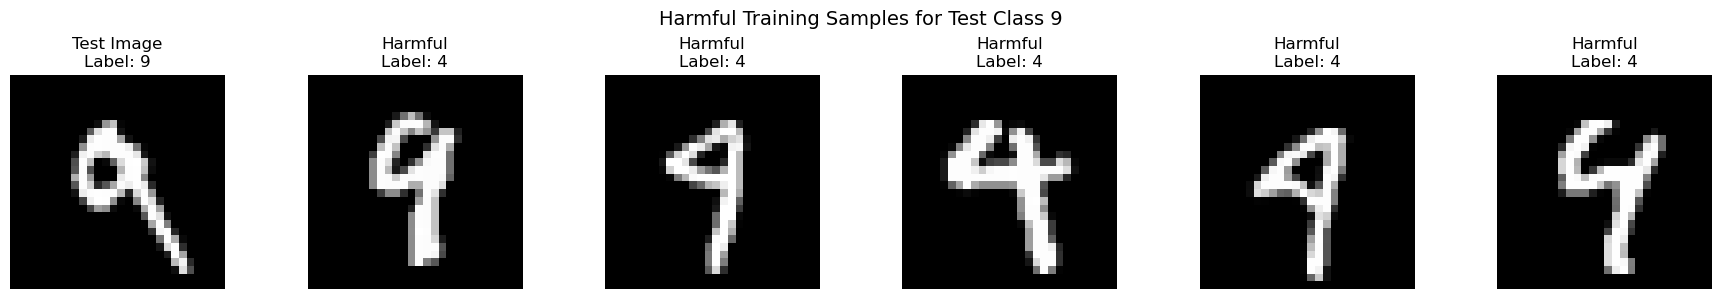

In [19]:
for j in range((len(selected_samples))):

    test_sample = selected_samples[j]
    test_label = j

    influences = get_influence_on_test_loss(model, train_loader, test_sample, test_label)

    # Sort influences to get the 5 most harmful (lowest influence scores)


    harmful_influences = sorted(influences, key=lambda x: x[0], reverse=True)[:5]

    # Plot test image + harmful training samples
    fig, axes = plt.subplots(1, 6, figsize=(18, 3))

    # Test image
    test_img = test_sample.squeeze()
    axes[0].imshow(test_img, cmap='gray')
    axes[0].set_title(f"Test Image\nLabel: {test_label}")
    axes[0].axis('off')

    # Harmful training samples
    for i in range(5):
        img = harmful_influences[i][1].squeeze()
        label = harmful_influences[i][2]
        axes[i + 1].imshow(img, cmap='gray')
        axes[i + 1].set_title(f"Harmful\nLabel: {label}")
        axes[i + 1].axis('off')

    plt.suptitle(f"Harmful Training Samples for Test Class {test_label}", fontsize=14)
    plt.tight_layout()
    plt.show()
